### This notebook's purpose is to get the CALCE data in a workable format (in a dataframe, cleaned, battery type labeled etc.)

### Goals: (Add to this)
1. Get files from CALCE website into dataframe(s)
2. Add label for every cycle which battery this data came from 
3. Find/Remove empty cells  (delete the whole row or should we do interpolation?) (Might not even have empty cells)


All CS2 cells underwent the same charging profile which was a standard constant current/constant voltage protocol with a constant current rate of 0.5C until the voltage reached 4.2V and then 4.2V was sustained until the charging current dropped to below 0.05A. Unless specified, the discharge cut off voltage for these batteries was 2.7V. All the CS2 cells were randomly numbered and named accordingly. Name 'CS2_n' was given for the nth numbered CS2 cell. 

#### Imports:

In [1]:
import scipy
import scipy.signal
import os 
import pandas as pd
import zipfile
import requests
import xlrd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import statistics as stats
from math import isclose
%matplotlib inline

#### Notes:
To import .mat files into python:  
import scipy.io   
mat = scipy.io.loadmat('file.mat')  

To unzip files: look at SEDS HW2 (not sure if we will use this)


#### CS2 data (in excel format*)  
Look at CS2 data first. From the website, CS2_'n' was given to the nth numbered CS2 cell (identifies unique cells from eachother). Each cell was cycled multiple times. Excel files are named using the testing dates.  **Were the same cells cycled on different dates or was the continuous cycling data split into multiple excel files?**   

*CS2_8 and CS2_21 are in .txt format because they were cycled using a different system.

Starting with CS2_33, in excel file format

In [2]:
data1 = pd.read_excel("data/CS2_33/CS2_33_10_04_10.xlsx", sheet_name= "Channel_1-006")
#it looks like all of these have the sheet name channel_1-006, not just this specific excel file? 
#would be nice to create a function to iterate over all the files in a given file and import them, store them in variable. 

In [3]:
data1['Cycle_Index'].max()
#this gives the number of cycles they ran

23

In [4]:
#we will need to clean the data so that dq/dv does not come back with weird data, ie we need to make sure the dq/dv isn't being 
# calculated between identical voltage values (because then dv = 0)
# (dq/dt)/(dv/dt)= dq/dv 
# (dq/dt) = current 


# calculate dv, find values close to 0, delete those rows, reindex, calculate dv again, 

New Column- To calculate dq/dv do discharge/charge capacity/ dv. calculate dv first. Ask robert whether to use discharge or charge capacity to calculate this. or do both and compare. Maybe ask user which capacity to use between discharge and charge - depends on system (i.e. Maccor) , which anode or cathode they are looking at etc. 

In [5]:
data1['dV'] = None 

In [6]:
data1.loc[2, ('Voltage(V)')]

3.4519877433776855

In [7]:
range(len(data1))

range(0, 10759)

In [8]:
for i in range(1,len(data1)): 
    data1.loc[i, ('dV')] = data1.loc[i, ('Voltage(V)')] - data1.loc[i-1, ('Voltage(V)')]


In [9]:
#data1['dQ/dV'] = data1['Discharge_Capacity(Ah)']/data1['dV']

In [126]:
data1['I/dv/dt'] = data1['Current(A)']/data1['dV/dt(V/s)']

In [127]:
data1.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),...,Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),dV,dQ/dV,filtered dq/dv,I/dv/dt
0,3,90.030676,2010-09-27 14:13:48,90.030677,1,1,0.000000,3.451988,0.000000,0.0,...,0.0,0.000000,0.0,0,0,0,0.000162,0.0,0.0,NaN
1,4,120.014848,2010-09-27 14:14:18,120.014848,1,1,0.000000,3.451826,0.000000,0.0,...,0.0,-0.000032,0.0,0,0,0,-0.000162,-0.0,0.0,-0.000000
2,5,150.030659,2010-09-27 14:14:48,30.015332,2,1,0.550025,3.584821,0.004585,0.0,...,0.0,0.001264,0.0,0,0,0,0.132995,0.0,0.0,435.294037
3,6,180.045864,2010-09-27 14:15:18,60.030537,2,1,0.549845,3.625319,0.009170,0.0,...,0.0,0.000972,0.0,0,0,0,0.040498,0.0,0.0,565.720562
4,7,210.061288,2010-09-27 14:15:48,90.045961,2,1,0.549845,3.658041,0.013755,0.0,...,0.0,0.000778,0.0,0,0,0,0.032722,0.0,0.0,707.168078


In [135]:
data1 = data1.dropna(subset=['I/dv/dt'])

In [136]:
data1.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),...,Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),dV,dQ/dV,filtered dq/dv,I/dv/dt
0,4,120.014848,2010-09-27 14:14:18,120.014848,1,1,0.000000,3.451826,0.000000,0.0,...,0.0,-0.000032,0.0,0,0,0,-0.000162,-0.0,0.0,-0.000000
1,5,150.030659,2010-09-27 14:14:48,30.015332,2,1,0.550025,3.584821,0.004585,0.0,...,0.0,0.001264,0.0,0,0,0,0.132995,0.0,0.0,435.294037
2,6,180.045864,2010-09-27 14:15:18,60.030537,2,1,0.549845,3.625319,0.009170,0.0,...,0.0,0.000972,0.0,0,0,0,0.040498,0.0,0.0,565.720562
3,7,210.061288,2010-09-27 14:15:48,90.045961,2,1,0.549845,3.658041,0.013755,0.0,...,0.0,0.000778,0.0,0,0,0,0.032722,0.0,0.0,707.168078
4,8,240.076447,2010-09-27 14:16:18,120.061120,2,1,0.549845,3.685742,0.018340,0.0,...,0.0,0.000680,0.0,0,0,0,0.027701,0.0,0.0,808.177888


In [139]:
data1 = data1.replace([np.inf, -np.inf], np.nan).dropna(subset=['I/dv/dt'])

In [140]:
data1.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),...,Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),dV,dQ/dV,filtered dq/dv,I/dv/dt
0,4,120.014848,2010-09-27 14:14:18,120.014848,1,1,0.000000,3.451826,0.000000,0.0,...,0.0,-0.000032,0.0,0,0,0,-0.000162,-0.0,0.0,-0.000000
1,5,150.030659,2010-09-27 14:14:48,30.015332,2,1,0.550025,3.584821,0.004585,0.0,...,0.0,0.001264,0.0,0,0,0,0.132995,0.0,0.0,435.294037
2,6,180.045864,2010-09-27 14:15:18,60.030537,2,1,0.549845,3.625319,0.009170,0.0,...,0.0,0.000972,0.0,0,0,0,0.040498,0.0,0.0,565.720562
3,7,210.061288,2010-09-27 14:15:48,90.045961,2,1,0.549845,3.658041,0.013755,0.0,...,0.0,0.000778,0.0,0,0,0,0.032722,0.0,0.0,707.168078
4,8,240.076447,2010-09-27 14:16:18,120.061120,2,1,0.549845,3.685742,0.018340,0.0,...,0.0,0.000680,0.0,0,0,0,0.027701,0.0,0.0,808.177888


In [141]:
data1 = data1.reset_index(drop = True)

In [142]:
data1['I/dv/dt']

0          -0.000000
1         435.294037
2         565.720562
3         707.168078
4         808.177888
5         942.852208
6         998.929118
7        1305.882080
8        1414.336155
9        1696.995217
10       4242.488233
11       8484.976466
12       8484.976466
13      16963.023897
14     -16976.890266
15       5657.114564
16      16963.023897
17       8487.753325
18      16957.474265
19       8484.976466
20       8484.976466
21      16982.448072
22       8484.976466
23      16982.448072
24       8484.976466
25       8482.199608
26       8494.002939
27       8494.002939
28       8484.976466
29       8491.224036
            ...     
9569       -0.000000
9570     1212.990680
9571     1886.521903
9572     2830.708373
9573     3395.517338
9574     3398.628104
9575     4243.632917
9576     3395.517338
9577     8496.293992
9578     5661.416745
9579     4246.409775
9580     5655.866422
9581     4245.021346
9582     5661.416745
9583     5661.416745
9584     3396.405637
9585     5663

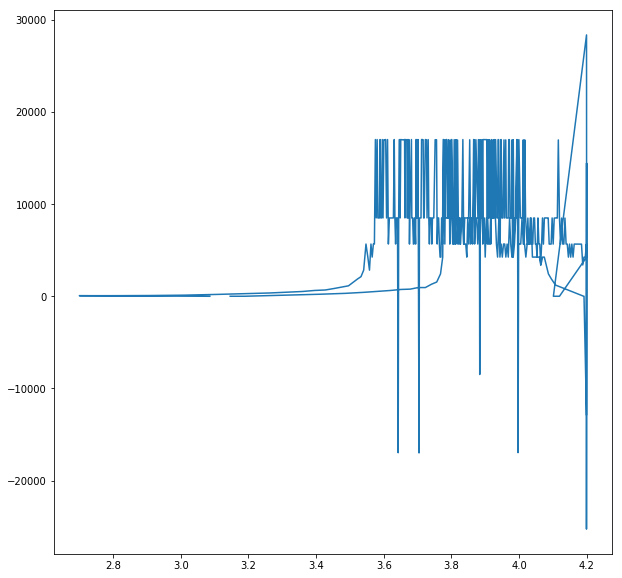

In [145]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 8:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['I/dv/dt'])

In [146]:
data1['dV'].describe()

count    9599.000000
mean       -0.000157
std         0.026837
min        -0.100435
25%        -0.002754
50%        -0.001134
75%         0.002268
max         0.432679
Name: dV, dtype: float64

In [147]:
#for i in range(1,len(data1)):
  #  if isclose(data1.loc[i, ('dV')], 0, abs_tol = 10**-3):
   #     data1 = data1.drop(index = i)


In [148]:
#len(data1)

In [149]:
#data1['dQ/dV-discharge cap'] = data1['Discharge_Capacity(Ah)']/data1['dV']

In [150]:
#data1['dQ/dV-charge cap'] = data1['Charge_Capacity(Ah)']/data1['dV']

In [151]:
unfilt = pd.concat([data1['dQ/dV']])

In [152]:
unfiltar = unfilt.values
#converts into an array 

In [153]:
unfiltar;

In [154]:
data1['filtered dq/dv'] = scipy.signal.savgol_filter(unfiltar, 7, 2)

In [155]:
data1.head(500)

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),...,Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),dV,dQ/dV,filtered dq/dv,I/dv/dt
0,4,120.014848,2010-09-27 14:14:18,120.014848,1,1,0.000000,3.451826,0.000000,0.000000,...,0.000000,-0.000032,0.000000,0,0,0,-0.000162,-0.000000,0.000000,-0.000000
1,5,150.030659,2010-09-27 14:14:48,30.015332,2,1,0.550025,3.584821,0.004585,0.000000,...,0.000000,0.001264,0.000000,0,0,0,0.132995,0.000000,0.000000,435.294037
2,6,180.045864,2010-09-27 14:15:18,60.030537,2,1,0.549845,3.625319,0.009170,0.000000,...,0.000000,0.000972,0.000000,0,0,0,0.040498,0.000000,0.000000,565.720562
3,7,210.061288,2010-09-27 14:15:48,90.045961,2,1,0.549845,3.658041,0.013755,0.000000,...,0.000000,0.000778,0.000000,0,0,0,0.032722,0.000000,0.000000,707.168078
4,8,240.076447,2010-09-27 14:16:18,120.061120,2,1,0.549845,3.685742,0.018340,0.000000,...,0.000000,0.000680,0.000000,0,0,0,0.027701,0.000000,0.000000,808.177888
5,9,270.091760,2010-09-27 14:16:48,150.076433,2,1,0.549845,3.709716,0.022925,0.000000,...,0.000000,0.000583,0.000000,0,0,0,0.023975,0.000000,0.000000,942.852208
6,10,300.107032,2010-09-27 14:17:18,180.091705,2,1,0.550205,3.731099,0.027510,0.000000,...,0.000000,0.000551,0.000000,0,0,0,0.021383,0.000000,0.000000,998.929118
7,11,330.122452,2010-09-27 14:17:48,210.107125,2,1,0.550025,3.749890,0.032095,0.000000,...,0.000000,0.000421,0.000000,0,0,0,0.018791,0.000000,0.000000,1305.882080
8,12,360.137626,2010-09-27 14:18:18,240.122299,2,1,0.549845,3.766737,0.036680,0.000000,...,0.000000,0.000389,0.000000,0,0,0,0.016847,0.000000,0.000000,1414.336155
9,13,390.152946,2010-09-27 14:18:48,270.137619,2,1,0.549845,3.779859,0.041265,0.000000,...,0.000000,0.000324,0.000000,0,0,0,0.013121,0.000000,0.000000,1696.995217


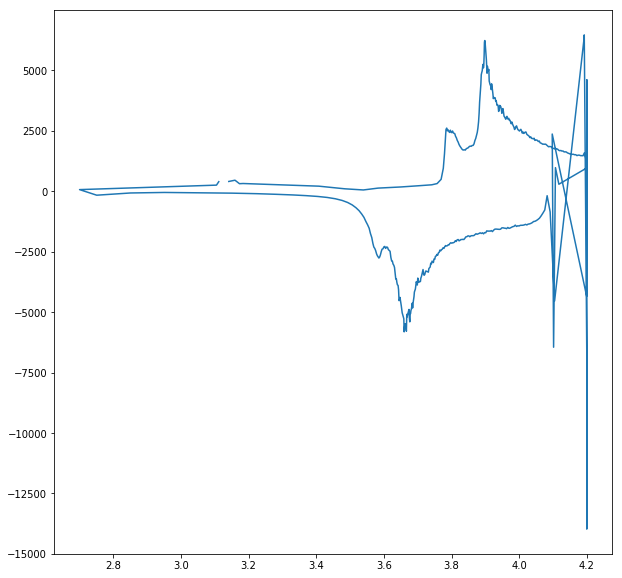

In [156]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 6:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['filtered dq/dv'])

Drop Rows With N/A or infinity in dq/dv-discharge cap row. First replace inf values for N/a values so can use dropna

In [ ]:
data1.replace([np.inf, -np.inf], np.nan)

In [ ]:
data1 = data1.replace([np.inf, -np.inf], np.nan).dropna(subset=["dQ/dV-discharge cap"])

In [ ]:
data1.dropna(subset=['dQ/dV-discharge cap'], inplace= True)

In [ ]:
data1['dQ/dV-discharge cap'].max()

In [ ]:
data1.shape

In [ ]:
data1.head()

Reindex and calculate dV again 

In [ ]:
data1 = data1.reset_index(drop = True)

In [ ]:
for i in range(1,len(data1)): 
    data1.loc[i, ('dV')] = data1.loc[i, ('Voltage(V)')] - data1.loc[i-1, ('Voltage(V)')]

Plot

In [ ]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 7:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['Discharge_Capacity(Ah)']/df1['dV'])

In [ ]:
data1['dQ/dV-charge cap'].max()

In [ ]:
data1['Cycle_Index'].max()

In [ ]:
gb = data1.groupby(by = ['Cycle_Index'])

In [ ]:
print(gb)

In [ ]:
for i in range(1, data1['Cycle_Index'].max() + 1):
    print(i)
    